In [ ]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Use Keras Model Architecture 

In [ ]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset Preparation 

In [ ]:
path = "/content/drive/My Drive/"
anns_file_path = "/content/drive/My Drive/annotations.json"

In [ ]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [ ]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [ ]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [ ]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [ ]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [ ]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [ ]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [ ]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [ ]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

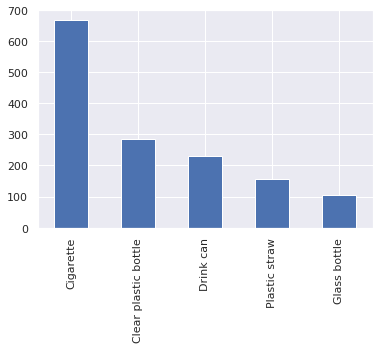

In [ ]:
df['category'].value_counts().plot.bar()

Data splitting into train and test data and keep this test data aside for model prediction
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Fetch, crop and store image data

In [ ]:
path

'/content/drive/My Drive/data/data/'

In [ ]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(path+'data/'+df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

In [ ]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df = pd.get_dummies(df, columns=["category"])
df.head()

In [ ]:
# Drop filename and convert the remaining into numpy array 
y = np.array(df.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1442, 5)
(1442, 128, 128, 3)


### Data Split 

In [ ]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

### Build Keras Model 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)       

## Keras Model Implementation Using 'Accuracy' Method

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 50)

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=100,batch_size=50, validation_split=0.20,callbacks = [early_stopper])


Train on 1037 samples, validate on 260 samples
Epoch 1/100
1037/1037 [==============================] - 30s 28ms/step - loss: 26.9669 - accuracy: 0.2758 - val_loss: 1.5780 - val_accuracy: 0.5346
Epoch 2/100
1037/1037 [==============================] - 29s 28ms/step - loss: 1.6056 - accuracy: 0.3491 - val_loss: 1.5676 - val_accuracy: 0.5115
Epoch 3/100
1037/1037 [==============================] - 28s 27ms/step - loss: 1.5610 - accuracy: 0.4330 - val_loss: 1.5280 - val_accuracy: 0.5000
Epoch 4/100
1037/1037 [==============================] - 28s 27ms/step - loss: 1.5018 - accuracy: 0.4378 - val_loss: 1.4464 - val_accuracy: 0.5000
Epoch 5/100
1037/1037 [==============================] - 29s 28ms/step - loss: 1.4136 - accuracy: 0.4446 - val_loss: 1.3423 - val_accuracy: 0.5154
Epoch 6/100
1037/1037 [==============================] - 30s 29ms/step - loss: 1.3065 - accuracy: 0.4899 - val_loss: 1.2521 - val_accuracy: 0.5192
Epoch 7/100
1037/1037 [==============================] - 31s 30ms/step

### Model Evaluation Based on Accuracy metrics

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

145/145 [==============================] - 1s 7ms/step
Train: 0.756, Test: 0.628


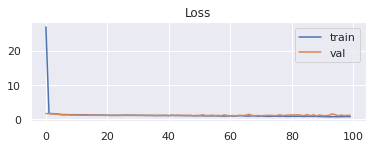

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()

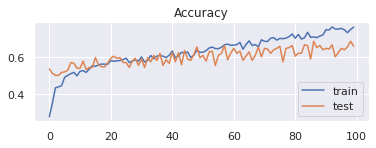

In [ ]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Model Prediction 

In [ ]:
classes = np.array(df.columns[1:])
proba = model.predict(X_test)

In [ ]:
all_5 = np.argsort(proba[0])
for i in range(5):
    print("{}".format(classes[all_5[i]])+" ({:.3})".format(proba[0][all_5[i]]))

category_Cigarette (0.0877)
category_Glass bottle (0.165)
category_Plastic straw (0.169)
category_Drink can (0.208)
category_Clear plastic bottle (0.371)
